In [25]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

import seaborn as sns




# Load Dataset

In [26]:
# Upload spam.dat manually before running this cell
df = pd.read_csv("spam.dat")

# Explore Dataset

In [27]:
print(df.shape)
df.head()

(4789, 463)


,ACT_NOW,ADDRESSES_ON_CD,ADULT_SITE,ADVERT_CODE,ADVERT_CODE2,ALL_CAPS_HEADER,ALL_CAP_PORN,ALL_NATURAL,AMATEUR_PORN,AMAZING,...,X_ENC_PRESENT,X_LIBRARY,X_LIST_UNSUBSCRIBE,X_MSMAIL_PRIORITY_HIGH,X_PRECEDENCE_REF,X_PRIORITY_HIGH,X_STORMPOST_TO,X_X_PRESENT,YOUR_INCOME,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,yes
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,yes
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,yes


# Preprocess Target & Check Missing Values

In [28]:
df['target'] = df['target'].map({'yes': 1, 'no': 0})
print("Missing values:", df.isnull().sum().sum())

Missing values: 0


# Split Dataset

In [29]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [30]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# Define all models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "k-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP (Neural Net)": MLPClassifier(max_iter=1000)
}

# Evaluation function
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    auc = roc_auc_score(y_test, y_prob)

    print(f"🔍 {name}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Sensitivity (Recall for Spam): {sensitivity:.4f}")
    print(f"Specificity (Recall for Non-Spam): {specificity:.4f}")
    print(f"FNR (Spam → Non-Spam): {fnr:.4f}")
    print(f"FPR (Non-Spam → Spam): {fpr:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 50)

# Loop through and evaluate all models
for name, model in models.items():
    evaluate_model(name, model)

🔍 Logistic Regression
Confusion Matrix:
[[590   0]
 [ 17 351]]
Sensitivity (Recall for Spam): 0.9538
Specificity (Recall for Non-Spam): 1.0000
FNR (Spam → Non-Spam): 0.0462
FPR (Non-Spam → Spam): 0.0000
AUC: 0.9990
--------------------------------------------------
🔍 Decision Tree
Confusion Matrix:
[[582   8]
 [ 12 356]]
Sensitivity (Recall for Spam): 0.9674
Specificity (Recall for Non-Spam): 0.9864
FNR (Spam → Non-Spam): 0.0326
FPR (Non-Spam → Spam): 0.0136
AUC: 0.9818
--------------------------------------------------
🔍 Random Forest
Confusion Matrix:
[[587   3]
 [ 11 357]]
Sensitivity (Recall for Spam): 0.9701
Specificity (Recall for Non-Spam): 0.9949
FNR (Spam → Non-Spam): 0.0299
FPR (Non-Spam → Spam): 0.0051
AUC: 0.9970
--------------------------------------------------
🔍 SVM
Confusion Matrix:
[[589   1]
 [ 18 350]]
Sensitivity (Recall for Spam): 0.9511
Specificity (Recall for Non-Spam): 0.9983
FNR (Spam → Non-Spam): 0.0489
FPR (Non-Spam → Spam): 0.0017
AUC: 0.9984
---------------

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring='recall',
    cv=5
)

grid.fit(X_train, y_train)

print("✅ Best C:", grid.best_params_['C'])


✅ Best C: 10


In [32]:
best_lr = grid.best_estimator_

y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob)

print("\n🔍 Tuned Logistic Regression Results")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")



🔍 Tuned Logistic Regression Results
Confusion Matrix:
 [[586   4]
 [ 15 353]]
Sensitivity (Recall): 0.9592
Specificity: 0.9932
FNR: 0.0408
FPR: 0.0068
AUC: 0.9978


# Apply RFE on Training Set

In [33]:
from sklearn.feature_selection import RFE

# Use Logistic Regression as the base model
lr = LogisticRegression(max_iter=1000)

# Set number of features to select (start with 50 or 100 out of ~460)
rfe = RFE(estimator=lr, n_features_to_select=100, step=50)
rfe.fit(X_train, y_train)

# Apply RFE to reduce both train and test features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


# Retrain Logistic Regression on Reduced Features

In [34]:
# Train on reduced features
lr_rfe = LogisticRegression(max_iter=1000)
lr_rfe.fit(X_train_rfe, y_train)

# Evaluate
y_pred_rfe = lr_rfe.predict(X_test_rfe)
y_prob_rfe = lr_rfe.predict_proba(X_test_rfe)[:, 1]

cm = confusion_matrix(y_test, y_pred_rfe)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob_rfe)

print("\n🔍 Logistic Regression with RFE (100 Features)")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")



🔍 Logistic Regression with RFE (100 Features)
Confusion Matrix:
 [[590   0]
 [ 19 349]]
Sensitivity (Recall): 0.9484
Specificity: 1.0000
FNR: 0.0516
FPR: 0.0000
AUC: 0.9987


# Apply PCA (Preserve 95% of Variance)

In [35]:
from sklearn.decomposition import PCA

# Apply PCA to training data
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original features:", X_train.shape[1])
print("Reduced features after PCA:", X_train_pca.shape[1])


Original features: 462
Reduced features after PCA: 182


# Train Logistic Regression on PCA Features

In [36]:
# Train model on PCA-transformed data
lr_pca = LogisticRegression(max_iter=1000)
lr_pca.fit(X_train_pca, y_train)

# Evaluate model
y_pred_pca = lr_pca.predict(X_test_pca)
y_prob_pca = lr_pca.predict_proba(X_test_pca)[:, 1]

cm = confusion_matrix(y_test, y_pred_pca)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob_pca)

print("\n🔍 Logistic Regression with PCA (95% Variance)")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")



🔍 Logistic Regression with PCA (95% Variance)
Confusion Matrix:
 [[589   1]
 [ 17 351]]
Sensitivity (Recall): 0.9538
Specificity: 0.9983
FNR: 0.0462
FPR: 0.0017
AUC: 0.9987


# Apply Oversampling and Undersampling

In [37]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Check class balance
print("Original class distribution:")
print(y_train.value_counts())

# Apply random oversampling
ros = RandomOverSampler(random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("\nOversampled class distribution:")
print(y_train_over.value_counts())

print("\nUndersampled class distribution:")
print(y_train_under.value_counts())


Original class distribution:
target
0    2359
1    1472
Name: count, dtype: int64

Oversampled class distribution:
target
0    2359
1    2359
Name: count, dtype: int64

Undersampled class distribution:
target
0    1472
1    1472
Name: count, dtype: int64


# Train and Evaluate on Oversampled Data

In [38]:
# Train on oversampled data
lr_over = LogisticRegression(max_iter=1000)
lr_over.fit(X_train_over, y_train_over)

y_pred_over = lr_over.predict(X_test)
y_prob_over = lr_over.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_over)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob_over)

print("\n🔍 Logistic Regression on Oversampled Data")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")



🔍 Logistic Regression on Oversampled Data
Confusion Matrix:
 [[589   1]
 [ 17 351]]
Sensitivity: 0.9538
Specificity: 0.9983
FNR: 0.0462
FPR: 0.0017
AUC: 0.9988


# Apply SMOTE

In [39]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print("SMOTE-balanced class distribution:")
print(y_train_smote.value_counts())


SMOTE-balanced class distribution:
target
0    2359
1    2359
Name: count, dtype: int64


# Train and Evaluate Model on SMOTE Data

In [40]:
# Train model on SMOTE data
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)

# Evaluate on original test set
y_pred_smote = lr_smote.predict(X_test)
y_prob_smote = lr_smote.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_smote)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob_smote)

print("\n🔍 Logistic Regression with SMOTE")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")



🔍 Logistic Regression with SMOTE
Confusion Matrix:
 [[589   1]
 [ 10 358]]
Sensitivity: 0.9728
Specificity: 0.9983
FNR: 0.0272
FPR: 0.0017
AUC: 0.9988


# Try Cost Weight = {0:1, 1:5}

In [41]:
# Cost-sensitive Logistic Regression
lr_weighted = LogisticRegression(max_iter=1000, class_weight={0: 1, 1: 5})
lr_weighted.fit(X_train, y_train)

y_pred_weighted = lr_weighted.predict(X_test)
y_prob_weighted = lr_weighted.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_weighted)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob_weighted)

print("🔍 Logistic Regression with class_weight={0:1, 1:5}")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")


🔍 Logistic Regression with class_weight={0:1, 1:5}
Confusion Matrix:
 [[583   7]
 [ 11 357]]
Sensitivity: 0.9701
Specificity: 0.9881
FNR: 0.0299
FPR: 0.0119
AUC: 0.9985


# Try Weight = {0:1, 1:10}

In [42]:
# Even higher weight to spam
lr_weighted_10 = LogisticRegression(max_iter=1000, class_weight={0: 1, 1: 10})
lr_weighted_10.fit(X_train, y_train)

y_pred_weighted_10 = lr_weighted_10.predict(X_test)
y_prob_weighted_10 = lr_weighted_10.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_weighted_10)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob_weighted_10)

print("🔍 Logistic Regression with class_weight={0:1, 1:10}")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")


🔍 Logistic Regression with class_weight={0:1, 1:10}
Confusion Matrix:
 [[575  15]
 [  6 362]]
Sensitivity: 0.9837
Specificity: 0.9746
FNR: 0.0163
FPR: 0.0254
AUC: 0.9982


# Train and Evaluate AdaBoost

In [43]:
from sklearn.ensemble import AdaBoostClassifier

# Create and train AdaBoost model
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

# Predict and evaluate
y_pred_ada = ada.predict(X_test)
y_prob_ada = ada.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_ada)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
auc = roc_auc_score(y_test, y_prob_ada)

print("🔍 AdaBoost Classifier")
print("Confusion Matrix:\n", cm)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"AUC: {auc:.4f}")


🔍 AdaBoost Classifier
Confusion Matrix:
 [[588   2]
 [ 22 346]]
Sensitivity: 0.9402
Specificity: 0.9966
FNR: 0.0598
FPR: 0.0034
AUC: 0.9935


# Top Important Features from Logistic Regression

In [46]:
# Re-train on full feature set (if not done already)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Get feature names and coefficients
feature_names = X.columns
coefficients = lr.coef_[0]

# Create a DataFrame of features and their importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Sort by absolute importance
top_features = importance_df.reindex(importance_df.Coefficient.abs().sort_values(ascending=False).index)

# Show top 10
top_features.head(10)


,Feature,Coefficient
53,CTYPE_JUST_HTML,4.104420
335,RESENT_TO,2.822755
441,WEB_BUGS,2.377806
385,SUBJ_FULL_OF_8BITS,1.947054
21,BASE64_ENC_TEXT,1.852790
111,FORGED_YAHOO_RCVD,1.800605
39,CLICK_BELOW,1.783094
250,MISSING_MIMEOLE,1.727684
400,TO_ADDRESS_EQ_REAL,1.658303
451,X_ACCEPT_LANG,-1.584935


# Visualize Top 10 *Features*

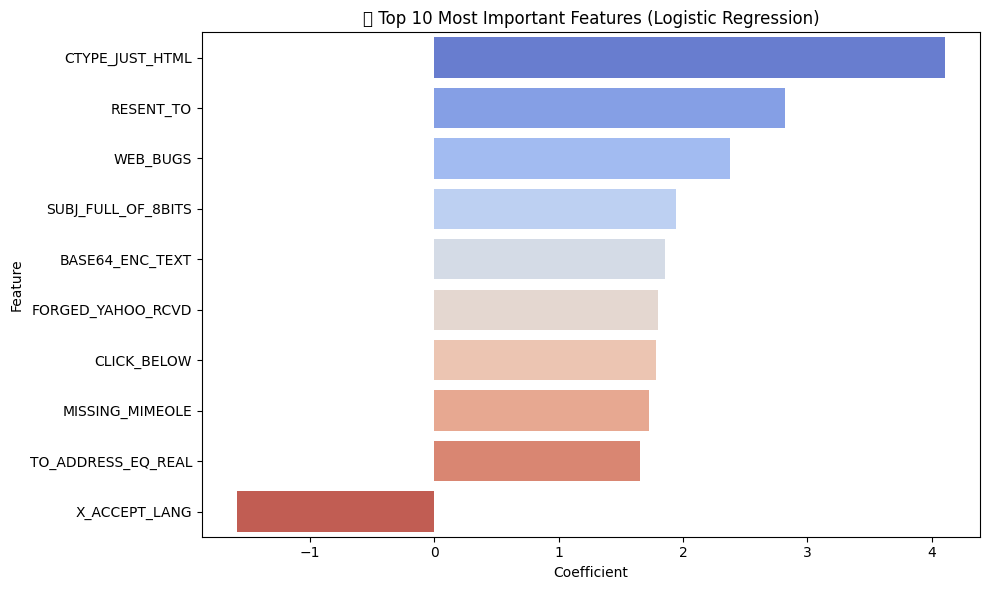

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_features.head(10),
    x="Coefficient",
    y="Feature",
    palette="coolwarm"
)
plt.title("🔍 Top 10 Most Important Features (Logistic Regression)")
plt.tight_layout()
plt.show()


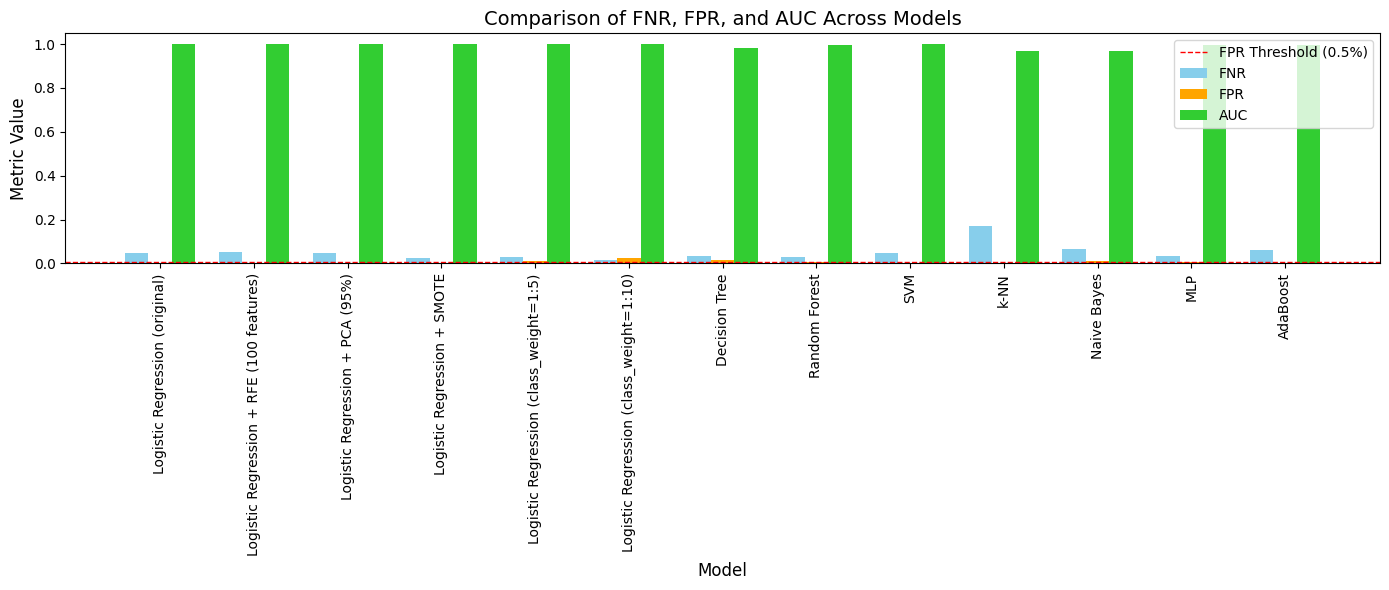

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Recreate the summary data (you can skip this part if you already have `summary_df`)
summary_data = {
    "Model": [
        "Logistic Regression (original)",
        "Logistic Regression + RFE (100 features)",
        "Logistic Regression + PCA (95%)",
        "Logistic Regression + SMOTE",
        "Logistic Regression (class_weight=1:5)",
        "Logistic Regression (class_weight=1:10)",
        "Decision Tree",
        "Random Forest",
        "SVM",
        "k-NN",
        "Naive Bayes",
        "MLP",
        "AdaBoost"
    ],
    "FNR": [0.0462, 0.0516, 0.0462, 0.0272, 0.0299, 0.0163, 0.0326, 0.0299, 0.0489, 0.1712, 0.0652, 0.0326, 0.0598],
    "FPR": [0.0000, 0.0000, 0.0017, 0.0017, 0.0119, 0.0254, 0.0136, 0.0051, 0.0017, 0.0017, 0.0119, 0.0051, 0.0034],
    "AUC": [0.9990, 0.9987, 0.9987, 0.9988, 0.9985, 0.9982, 0.9818, 0.9970, 0.9984, 0.9696, 0.9667, 0.9964, 0.9935]
}
summary_df = pd.DataFrame(summary_data)

# Plot configuration
plt.figure(figsize=(14, 6))
bar_width = 0.25
index = np.arange(len(summary_df))

# Bar plots
plt.bar(index, summary_df['FNR'], bar_width, label='FNR', color='skyblue')
plt.bar(index + bar_width, summary_df['FPR'], bar_width, label='FPR', color='orange')
plt.bar(index + 2 * bar_width, summary_df['AUC'], bar_width, label='AUC', color='limegreen')

# Labels and formatting
plt.xlabel('Model', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Comparison of FNR, FPR, and AUC Across Models', fontsize=14)
plt.xticks(index + bar_width, summary_df['Model'], rotation=90)
plt.axhline(0.005, color='red', linestyle='--', linewidth=1, label='FPR Threshold (0.5%)')
plt.legend()
plt.tight_layout()
plt.show()
